# Run AOS on real images

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
from flow_analysis_comps.processing.Multiori.OrientationSpaceManager import (
    orientationSpaceManager,
)
import colorcet  # noqa: F401
from flow_analysis_comps.data_structs.kymograph_structs import (
    kymoExtractConfig,
)
import colorcet as cc
from flow_analysis_comps.data_structs.multiori_config_struct import angle_filter_values, multiOriParams
import flow_analysis_comps.io as io
import flow_analysis_comps.processing as process

%matplotlib widget

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
video_root_folder = Path(
    r"/home/svstaalduine/test_folder_data/134438"
)
video_metadata = io.read_video_metadata(video_root_folder)

multiori_mask_params = multiOriParams(
    space_frequency_center=0.5,
    orientation_accuracy=16.0,
    x_spacing=video_metadata.deltas.delta_x,
    y_spacing=video_metadata.deltas.delta_t,
    padding=50,
    multires_filter_params=angle_filter_values(
        magnitude=0.01, first_derivative=0.1, second_derivative=5.0
    ),
)
# first_im = io.read_video_array(video_metadata)[0].compute()
print("Read Metadata")
mask = process.video_to_mask(video_metadata)
# other_mask = process.multiori_direction_mask(video_metadata, multiori_mask_params)

Read Metadata


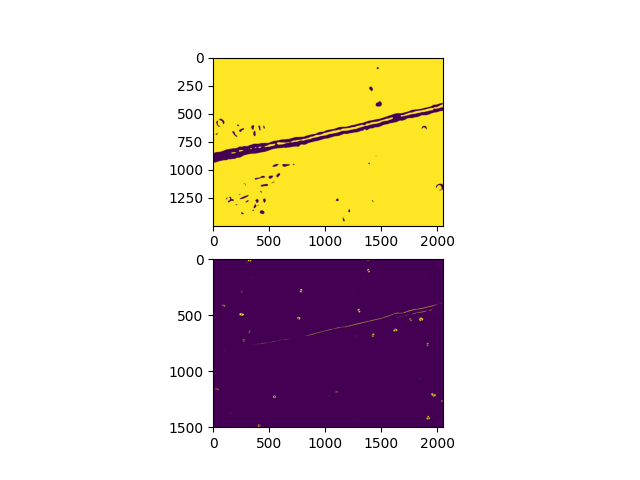

In [6]:
fig, ax = plt.subplots(2)
ax[0].imshow(mask)
ax[1].imshow(other_mask)

In [ ]:
graph_data = process.extract_graph_from_video(video_metadata)
print("Extracted Graph")
kymograph_list = process.extract_kymographs_from_video(
    video_metadata, graph_data, kymoExtractConfig()
)

AOS_params = multiOriParams(
    space_frequency_center=0.1,
    orientation_accuracy=24.0,
    x_spacing=video_metadata.deltas.delta_x,
    y_spacing=video_metadata.deltas.delta_t,
    padding=50,
    multires_filter_params=angle_filter_values(
        magnitude=0.01, first_derivative=0.1, second_derivative=7.0
    ),
)
AOS_manager = orientationSpaceManager(AOS_params, kymograph_list[0].kymo_no_static) # type: ignore

In [ ]:
angles_dict = AOS_manager.get_all_angles()

In [ ]:
import numpy as np

unpad = 50

angles_im = angles_dict["maxima"]
angles_im_trunc = angles_im[:, unpad:-unpad, unpad:-unpad]
values_im = angles_dict["values_max"]

fig, ax = plt.subplot_mosaic(
    [
        ["Ori1", "Ori2", "Ori3"],
        [
            "Histo",
            "Histo",
            "Histo",
        ],
    ]
)

for i, im in enumerate(angles_im[:3]):
    ax[f"Ori{i + 1}"].imshow(
        im.real, cmap=cc.cm.rainbow4, vmin=-np.pi / 2, vmax=np.pi/2, aspect="auto"
    )

ax["Histo"].hist(angles_im[~np.isnan(angles_im)], bins=360, density=True, alpha=0.3, range=(-np.pi / 2, np.pi / 2))
ax["Histo"].hist(angles_im_trunc[~np.isnan(angles_im_trunc)], bins=360, density=True, range=(-np.pi / 2, np.pi / 2))
ax["Histo"].axvline(0, label="Middle")
ax["Histo"].set_xlim(-np.pi / 2, np.pi / 2)
ax["Histo"].legend()
fig.tight_layout()

# Test with test data

In [ ]:
from flow_analysis_comps.test_data import single_line_img, crossing_line_img
from flow_analysis_comps.util.image_manips import mirror_pad_with_exponential_fade
import numpy as np
import skimage

single_line_angle = 75
multi_line_angles = np.array([0, 75, 20])
imsize = 100

test_single = single_line_img(single_line_angle, std_dev=1, img_size=(imsize, imsize))
test_crossing = crossing_line_img(
    multi_line_angles, [0.8, 1, 1.4], img_size=(imsize, imsize)
)

test_single = skimage.util.random_noise(test_single, mode="gaussian", var=0.01)
test_crossing = skimage.util.random_noise(test_crossing, mode="gaussian", var=0.1)

# test_single = mirror_pad_with_exponential_fade(test_single, pad)
# test_crossing = mirror_pad_with_exponential_fade(test_crossing, pad)

fig, ax = plt.subplots(2)
ax[0].imshow(test_single)
ax[1].imshow(test_crossing)

In [ ]:
from flow_analysis_comps.data_structs.multiori_config_struct import angle_filter_values


AOS_params = multiOriParams(
    space_frequency_center=0.2,
    # space_frequency_width=0.3,
    orientation_accuracy=24,
    x_spacing=1,
    y_spacing=1,
    padding=30,
    multires_filter_params=angle_filter_values(
        magnitude=0.01, first_derivative=0.1, second_derivative=11.0
    ),
)

AOS_manager = orientationSpaceManager(AOS_params, test_crossing)

filter_arrays = AOS_manager.filter_arrays

angles_dict = AOS_manager.get_max_angles()
nlms_mask = AOS_manager.nlms_simple_case()

In [ ]:
import numpy as np

full_orientation = np.rad2deg(angles_dict)
nlms_orientation = np.where(nlms_mask, np.rad2deg(angles_dict), np.nan)

fig, ax = plt.subplot_mosaic(
    [["Orientation", "NLMS_orientation"], ["Histograms", "Histograms"]]
)
ax["Orientation"].imshow(full_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["NLMS_orientation"].imshow(nlms_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["Histograms"].hist(
    full_orientation.flatten(),
    bins=180,
    range=(0, 180),
    density=True,
    alpha=0.5,
    label="all pixels",
    color="red",
)
ax["Histograms"].hist(
    nlms_orientation.flatten(),
    bins=180,
    range=(0, 180),
    density=True,
    alpha=0.5,
    label="NLMS Pixels",
    color="green",
)
ax["Histograms"].axvline(45)
ax["Histograms"].axvline(135)
ax["Histograms"].axvline(single_line_angle, c="red")
ax["Histograms"].axvline((single_line_angle + 90) % 180, c="red")
ax["Histograms"].legend()

In [ ]:
output_dict = AOS_manager.get_all_angles()

unpad = 20

angles_im = output_dict["maxima"]
angles_im_trunc = angles_im[:, unpad:-unpad, unpad:-unpad]
values_im = output_dict["values_max"]

fig, ax = plt.subplot_mosaic(
    [
        ["Ori1", "Ori2", "Ori3", "Ori4"],
        [
            "Histo",
            "Histo",
            "Histo",
            "Histo",
        ],
    ]
)

for i, im in enumerate(angles_im[:4]):
    ax[f"Ori{i + 1}"].imshow(im.real, cmap=cc.cm.rainbow4, vmin=-np.pi / 2, vmax=np.pi / 2)
ax["Histo"].hist(angles_im[~np.isnan(angles_im)], bins=360, density=True, alpha=0.3, range=(-np.pi / 2, np.pi / 2))
ax["Histo"].hist(angles_im_trunc[~np.isnan(angles_im_trunc)], bins=360, density=True, range=(-np.pi / 2, np.pi / 2))
for angle in multi_line_angles:
    angle_adj = -1 *((angle + 90) % 180  - 180)
    ax["Histo"].axvline(
        np.deg2rad(angle_adj), label=rf"$\theta={angle_adj}$", alpha=0.2
    )
ax["Histo"].legend()
fig.tight_layout()